In [1]:
import os, sys
import importlib
from scipy import ndimage
import cv2
import medmnist
import numpy as np
import pandas as pd
import torch.utils.data as data
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tqdm import tqdm
from medmnist import INFO, Evaluator

## Load pathmnist 

In [2]:
data_flag = 'pathmnist'
download = True
BATCH_SIZE = 16
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

In [43]:
data_transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = DataClass(split='train', transform=data_transform, download=download)

Using downloaded and verified file: /home/t-kbouzid/.medmnist/pathmnist.npz


In [44]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [45]:
sample, label = next(iter(train_loader))
sample.shape

torch.Size([16, 3, 28, 28])

In [46]:
train_dataset.montage(length=1)

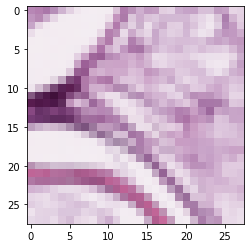

In [47]:
# img = cv2.merge((sample[0, 0], sample[0, 1], sample[0, 2]))
plt.imshow(np.transpose(sample[2], (1,2,0)))

In [36]:
sample.min()

tensor(-0.8275)

In [49]:
channels, fill_val = 3, 25
n_patches, n_diag, patch_size = 2, 5, 28
img_size = n_patches * n_diag * patch_size
step_size = n_patches * patch_size

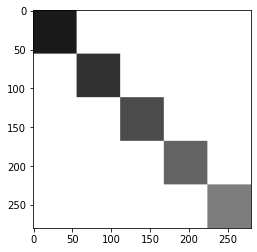

In [50]:
mock_image = np.full(shape=(channels, img_size, img_size), fill_value=255)
for i in range(n_diag):
    mock_image[:, step_size * i:step_size * (i+1), step_size * i:step_size * (i+1)] = fill_val * (i+1)
plt.imshow(np.transpose(mock_image, (1,2,0)))

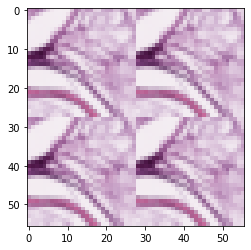

In [51]:
plt.imshow(np.transpose(np.tile(sample[2], (2, 2)), (1,2,0)), interpolation="none")

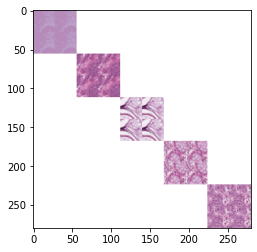

In [88]:
mock_image = np.full(shape=(channels, img_size, img_size), fill_value=255, dtype=np.uint8)
for i in range(n_diag):
    mock_image[:, step_size * i:step_size * (i+1), step_size * i:step_size * (i+1)] = np.tile(sample[i], (2, 2))*255
plt.imshow(np.transpose(mock_image, (1,2,0)))

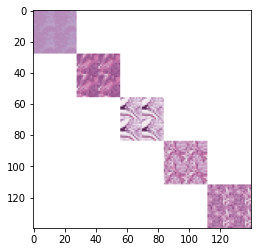

In [80]:
plt.imshow(np.transpose(mock_image[:, ::2, ::2], (1,2,0)))

## Save mock as tiff file

### Test with pylibtiff

In [20]:
from libtiff import TIFFfile, TIFFimage, TIFF
from scipy import ndimage

In [21]:
ndimage.zoom(mock_image, (1, 2, 2)).shape

(3, 560, 560)

In [13]:
data = [mock_image, ndimage.zoom(mock_image, (1, 2, 2))]

In [54]:
tiff = TIFFimage(mock_image, description="")
tiff.write_file('mock2.tiff', compression='lzw') # or 'lzw'

NameError: name 'TIFFimage' is not defined

In [37]:
mock_image.shape

(3, 280, 280)

In [38]:
tif = TIFFfile('mock.tiff')
samples, sample_names = tif.get_samples()

In [39]:
len(samples)

1

In [40]:
samples[0].shape

(3, 280, 280)

In [41]:
sample_names

['sample0']

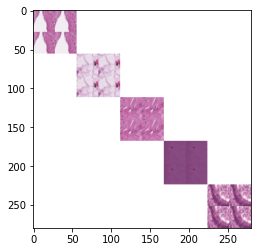

In [42]:
plt.imshow(np.transpose(samples[0], (1,2,0)))

In [161]:
dt = np.dtype(dict(names=list('rgb'), formats=[np.uint8]*3))
image = np.zeros((2, 3), dtype=dt)
image['r'][:, 0] = 250
image['g'][:, 1] = 251
image['b'][:, 2] = 252

In [163]:
arr = np.zeros((5, 6, 4), np.uint8)
for i in np.ndindex(*arr.shape):
    arr[i] = 20 * i[0] + 10 * i[1] + i[2]
print(arr.shape)

(5, 6, 4)


### Test with Tiffile package

In [89]:
from tifffile import imwrite, imread, TiffWriter
mock_image = np.full(shape=(channels, img_size, img_size), fill_value=255, dtype=np.uint8)
for i in range(n_diag):
    mock_image[:, step_size * i:step_size * (i+1), step_size * i:step_size * (i+1)] = np.tile(sample[i], (2, 2))*255
mock_image = np.transpose(mock_image, (1, 2, 0)) 
serie1 = mock_image
serie2 = mock_image[::2, ::2]
serie3 = mock_image[::4, ::4]

In [90]:
serie1.shape

(280, 280, 3)

In [91]:
imwrite('mock.tiff', serie1, photometric='rgb', compression="jpeg")

In [92]:
with TiffWriter('temp.tiff', bigtiff=True) as tif:
    options = dict(photometric='rgb', compression='jpeg')
    tif.write(serie1, **options)
    # save pyramid levels to the two subifds
    # in production use resampling to generate sub-resolutions
    tif.write(serie2, subfiletype=1, **options)
    tif.write(serie3, subfiletype=1, **options)

In [103]:
test = imread("temp.tiff", level=2)
test.shape

(70, 70, 3)

In [98]:
from monai.data.image_reader import WSIReader
reader = WSIReader(backend="cucim", level=0)
monai_test = reader.read('temp.tiff')
monai_test.shape

[280, 280, 3]

In [39]:
imwrite('mock.tiff', serie1, photometric='rgb', bigtiff=True, compression="zlib")
imwrite('mock.tiff', serie2, photometric='rgb', append=True, bigtiff=True, compression="zlib")
imwrite('mock.tiff', serie3, photometric='rgb', append=True, bigtiff=True, compression="zlib")

In [48]:
for i in range(3):
    image = imread('mock.tiff', series=i)
    print(image.shape)

(280, 280, 3)
(308, 308, 3)
(370, 370, 3)


In [52]:
1.2*28

33.6

## PANDA TEST

In [5]:
int(0 > 0)

0